In [3]:
import sys
sys.path.append('./')
import numpy as np
import os
import datetime
import keras.backend as K
import tensorflow as tf
from keras.layers import Conv2D, Dense, DepthwiseConv2D,add
from keras.optimizers import SGD, Adam
from keras.optimizers import legacy
import numpy as np
import math
import keras
from PIL import Image
from random import shuffle
from keras import layers as KL
from Anchors import get_anchors
from infer_anchor_direct_train import infer_anchor
from Datasets import SSDDatasets
from learning_rate import WarmUpCosineDecayScheduler
from loss import MultiboxLoss
from Models import SSD300
from utils import get_classes, show_config
from log_record import record_log, read_log
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard)
from callbacks import (ExponentDecayScheduler, LossHistory,
                       ParallelModelCheckpoint, EvalCallback)


2023-09-22 11:54:19.349152: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-22 11:54:19.377672: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-22 11:54:19.378155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 11:54:20.162473: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
from keras.regularizers import l2

if __name__ == "__main__":
    
    # 设置训练参数
    Epoch = 150  # 训练100 epochs
    lr = 1e-3  # Adam优化器，所以较小的学习率
    optimizer_type = "Adam"
    momentum = 0.937
    batch_size = 32
    imgcolor = 'grey'  # imgcolor选“rgb” or “grey”, 则处理图像变单通道或者三通道
    tmp_dir = str(datetime.datetime.strftime(datetime.datetime.now(), '%Y%m%d'))
    save_dir = "/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/"+tmp_dir
    
    # 设置SSD参数
    cls_name_path = "./model_data/voc_classes.txt"  # 导入目标检测类别；
    input_shape = [120, 160]  # 输入的尺寸大小
    anchor_size = [32, 59, 86, 113, 141, 168]  # 用于设定先验框的大小，根据公式计算而来；如果要检测小物体，修改浅层先验框的大小，越小的话，识别的物体越小；    
    train_annotation_path = '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/Img_Pro/preprocessing/2007_trainval.txt'  # 训练图片路径和标签
    val_annotation_path = '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/Img_Pro/preprocessing/2007_test.txt'  # 验证图片路径和标签
    
    # 1. 获取classes和anchor
    class_names, num_cls = get_classes(cls_name_path)
    num_cls += 1  # 增加一个背景类别
    print("class_names:", class_names, "num_classes:", num_cls)
    
    # 2. 获取anchors, 输出的是归一化之后的anchors
    # anchor = get_anchors(input_shape, anchor_size)
    anchor = infer_anchor()
    print("type:",type(anchor), "shape:", np.shape(anchor))

    # 3. 模型编译
    K.clear_session()
    model_path = ""
    # model_path = "./output/20230804_3/good_detection_test_callback.h5"
    model = SSD300((input_shape[0], input_shape[1], 1), num_cls)
    # model.save("template.h5")
    # model.summary()
    if model_path != "":
        model.load_weights(model_path, by_name = True, skip_mismatch=True)
       
    # 4. 优化器
    # optimizer = Adam(lr = lr, beta_1=momentum)
    # optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    optimizer = legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)  # 2.10新特性，Adam要从legacy里面提取
    
    # 5. 导入数据集
    with open(train_annotation_path, encoding='utf-8') as f:
        train_lines = f.readlines()
    with open(val_annotation_path, encoding='utf-8') as f:
        val_lines = f.readlines()
    num_train = len(train_lines)
    num_val = len(val_lines)
    epoch_step = num_train // batch_size
    epoch_step_val = num_val // batch_size
    train_dataloader = SSDDatasets(train_lines, input_shape, anchor, batch_size, num_cls, train=False, imgcolor=imgcolor)
    val_dataloader = SSDDatasets(val_lines, input_shape, anchor, batch_size, num_cls, train=False, imgcolor=imgcolor)
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    
    # 6. 编译模型
    # losses = {'mbox_loc_final':MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_loc_loss,
            #   'cls_conf_final':MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_conf_loss}
    # losses2 = [MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_loc_loss,MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_conf_loss]
    model.compile(optimizer=optimizer, loss = MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_loss)
    
    # 7. 设计learning rate;
    total_steps = int(Epoch * num_train / batch_size)
    # 7.1 compute the number of warmup batches.
    warmup_epochs = 10
    warmup_steps = int(warmup_epochs * num_train / batch_size)
    # 7.2 create the learning rate scheduler
    warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=lr,
                                            total_steps=total_steps,
                                            warmup_learning_rate=4e-06,
                                            warmup_steps=warmup_steps,
                                            hold_base_rate_steps=20)
    time_str = datetime.datetime.strftime(datetime.datetime.now(), '%Y_%m_%d_%H_%M_%S')
    log_dir = os.path.join(save_dir, "loss_" + str(time_str))
    
    # # 8. 精度评价: pending --> 还没构建；
    eval_flag = True
    eval_period = 10
    eval_callback = EvalCallback(model, input_shape, anchor, class_names, num_cls, val_lines, log_dir, eval_flag=eval_flag, period = eval_period)
    show_config(
        classes_path=cls_name_path, model_path=model_path, input_shape=input_shape, \
        Epoch=Epoch, batch_size=batch_size, \
        lr=lr, optimizer_type=optimizer_type, momentum=momentum, \
        num_train=num_train, num_val=num_val
    )
    
    callbacks_list = [
        # 早停回调，keras.callbacks.EarlyStopping(monitor='val_accuracy'， patience=4)
        warm_up_lr, # 学习率的调整
        # 学习率调整方法2. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto',min_lr=0.000001),
        # Epoch结束回调LearningRateSchrduler(schrduler, verbose=1),
        keras.callbacks.TensorBoard(log_dir=os.path.join(save_dir, 'unetlogs'), update_freq=1000), #参数分别为日志存储路径和每多少step进行一次记录，此处不应取太小，会拖慢训练过程
        eval_callback,  # 精度评价；
    ]
    # 8. 开始训练；
    history = model.fit_generator(
        generator=train_dataloader,
        steps_per_epoch=epoch_step,
        validation_data=val_dataloader,
        validation_steps=epoch_step_val,
        epochs=Epoch,
        # callbacks = [warm_up_lr]
        callbacks = callbacks_list   
    )  # 使用tensorboard --logdir="" 调用查看loss
    
    record_log(history, filename = os.path.join(save_dir, "unetlogs/log.txt"))
    model.save(os.path.join(save_dir, "good_detection_test_callback_2.h5"))
    model.save(os.path.join(save_dir, "good_detection_test_callback_2.pb"))

class_names: ['good'] num_classes: 2
[[0.         0.         0.05       0.0875    ]
 [0.         0.         0.06875    0.125     ]
 [0.03125    0.         0.09375    0.0875    ]
 ...
 [0.         0.27083333 0.840625   0.79583333]
 [0.253125   0.         0.546875   1.        ]
 [0.121875   0.04166667 0.678125   1.        ]]
type: <class 'numpy.ndarray'> shape: (1242, 4)
Train on 1603 samples, val on 179 samples, with batch size 32.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.


2023-09-22 11:54:22.446420: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-09-22 11:54:22.512412: W tensorflow/c/c_api.cc:304] Operation '{name:'DepthwiseConv2D_conf_DD5_1/depthwise_kernel/Assign' id:1483 op device:{requested: '', assigned: ''} def:{{{node DepthwiseConv2D_conf_DD5_1/depthwise_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](DepthwiseConv2D_conf_DD5_1/depthwise_kernel, DepthwiseConv2D_conf_DD5_1/depthwise_kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/tmp/ipykernel_27644/3542921995.py:100: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history 

Configurations:
----------------------------------------------------------------------
|                     keys |                                   values|
----------------------------------------------------------------------
|             classes_path |             ./model_data/voc_classes.txt|
|               model_path |                                         |
|              input_shape |                               [120, 160]|
|                    Epoch |                                      150|
|               batch_size |                                       32|
|                       lr |                                    0.001|
|           optimizer_type |                                     Adam|
|                 momentum |                                    0.937|
|                num_train |                                     1603|
|                  num_val |                                      179|
-------------------------------------------------------------

2023-09-22 11:54:22.765402: W tensorflow/c/c_api.cc:304] Operation '{name:'beta_1/Assign' id:1911 op device:{requested: '', assigned: ''} def:{{{node beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta_1, beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-09-22 11:54:23.761177: W tensorflow/c/c_api.cc:304] Operation '{name:'loss/AddN' id:1780 op device:{requested: '', assigned: ''} def:{{{node loss/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul, loss/Conv2D_layer13/kernel/Regularizer/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sess

 3/50 [>.............................] - ETA: 3s - batch: 1.0000 - size: 32.0000 - loss: 7.4767     

2023-09-22 11:54:24.439880: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-09-22 11:54:24.439899: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-09-22 11:54:24.511831: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-09-22 11:54:24.513344: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-09-22 11:54:24.513683: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: /home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230922/unetlogs/plugins/profile/2023_09_22_11_54_24/SSSLXSRVLS001.xplane.pb


50/50 [==============================] - ETA: 0s - batch: 24.5000 - size: 32.0000 - loss: 7.4700

/home/zhangyouan/anaconda3/envs/stc/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-09-22 11:54:27.863666: W tensorflow/c/c_api.cc:304] Operation '{name:'loss/AddN' id:1780 op device:{requested: '', assigned: ''} def:{{{node loss/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul, loss/Conv2D_layer13/kernel/Regularizer/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


50/50 [==============================] - 5s 76ms/step - batch: 24.5000 - size: 32.0000 - loss: 7.4700 - val_loss: 7.5092
Epoch 2/150
50/50 [==============================] - 4s 74ms/step - batch: 24.5000 - size: 32.0000 - loss: 7.4251 - val_loss: 7.4262
Epoch 3/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 7.2641 - val_loss: 7.0685
Epoch 4/150
50/50 [==============================] - 4s 74ms/step - batch: 24.5000 - size: 32.0000 - loss: 6.5281 - val_loss: 6.2475
Epoch 5/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 6.0103 - val_loss: 5.8043
Epoch 6/150
50/50 [==============================] - 4s 74ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.5717 - val_loss: 5.5082
Epoch 7/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.3776 - val_loss: 5.3811
Epoch 8/150
50/50 [==============================] - 4s 80ms/step - batch: 24.500

  0%|          | 0/179 [00:00<?, ?it/s]/home/zhangyouan/anaconda3/envs/stc/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-09-22 11:55:01.882548: W tensorflow/c/c_api.cc:304] Operation '{name:'predictions/concat' id:1603 op device:{requested: '', assigned: ''} def:{{{node predictions/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _has_manual_control_dependencies=true](mbox_loc_final/Reshape, cls_conf_final/Softmax, predictions/concat/axis)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
100%|██████████| 179/179 [00:01<00:00, 132.56it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
2.67% = good AP 	||	score_threhold=0.5 : F1=0.00 ; Recall=0.00% ; Precision=0.00%
mAP = 2.67%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230922/loss_2023_09_22_11_54_22' created successfully.
Get map done.
50/50 [==============================] - 6s 124ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.1765 - val_loss: 5.2521
Epoch 11/150
50/50 [==============================] - 4s 74ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.1413 - val_loss: 5.2000
Epoch 12/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.1346 - val_loss: 5.1713
Epoch 13/150
50/50 [==============================] - 4s 74ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.1188 - val_loss: 5.1831
Epoch 14/150
50/50 [==============================] - 4s 74ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.0960 - val_loss

100%|██████████| 179/179 [00:01<00:00, 144.11it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
11.82% = good AP 	||	score_threhold=0.5 : F1=0.01 ; Recall=0.56% ; Precision=100.00%
mAP = 11.82%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230922/loss_2023_09_22_11_54_22' already exists.
Get map done.
50/50 [==============================] - 6s 122ms/step - batch: 24.5000 - size: 32.0000 - loss: 4.9931 - val_loss: 4.9050
Epoch 21/150
50/50 [==============================] - 4s 74ms/step - batch: 24.5000 - size: 32.0000 - loss: 4.7452 - val_loss: 4.5446
Epoch 22/150
50/50 [==============================] - 4s 77ms/step - batch: 24.5000 - size: 32.0000 - loss: 4.4399 - val_loss: 4.2357
Epoch 23/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 4.0786 - val_loss: 3.9487
Epoch 24/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 3.9172 - val_loss: 

100%|██████████| 179/179 [00:01<00:00, 154.12it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
81.26% = good AP 	||	score_threhold=0.5 : F1=0.81 ; Recall=75.98% ; Precision=87.18%
mAP = 81.26%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230922/loss_2023_09_22_11_54_22' already exists.
Get map done.
50/50 [==============================] - 6s 121ms/step - batch: 24.5000 - size: 32.0000 - loss: 2.8289 - val_loss: 2.7606
Epoch 31/150
50/50 [==============================] - 4s 74ms/step - batch: 24.5000 - size: 32.0000 - loss: 2.7683 - val_loss: 2.6984
Epoch 32/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 2.6547 - val_loss: 2.7703
Epoch 33/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 2.5868 - val_loss: 2.5249
Epoch 34/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 2.4494 - val_loss: 

100%|██████████| 179/179 [00:01<00:00, 170.77it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
91.11% = good AP 	||	score_threhold=0.5 : F1=0.89 ; Recall=83.24% ; Precision=95.51%
mAP = 91.11%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230922/loss_2023_09_22_11_54_22' already exists.
Get map done.
50/50 [==============================] - 6s 122ms/step - batch: 24.5000 - size: 32.0000 - loss: 2.1602 - val_loss: 2.1180
Epoch 41/150
50/50 [==============================] - 4s 76ms/step - batch: 24.5000 - size: 32.0000 - loss: 2.0507 - val_loss: 2.1400
Epoch 42/150
50/50 [==============================] - 4s 76ms/step - batch: 24.5000 - size: 32.0000 - loss: 2.0073 - val_loss: 2.1592
Epoch 43/150
50/50 [==============================] - 4s 76ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.9881 - val_loss: 2.2068
Epoch 44/150
50/50 [==============================] - 4s 78ms/step - batch: 24.5000 - size: 32.0000 - loss: 2.0323 - val_loss: 

100%|██████████| 179/179 [00:00<00:00, 202.83it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
91.27% = good AP 	||	score_threhold=0.5 : F1=0.91 ; Recall=86.03% ; Precision=96.25%
mAP = 91.27%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230922/loss_2023_09_22_11_54_22' already exists.
Get map done.
50/50 [==============================] - 5s 98ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.7650 - val_loss: 1.9680
Epoch 51/150
50/50 [==============================] - 4s 76ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.7804 - val_loss: 1.9281
Epoch 52/150
50/50 [==============================] - 4s 74ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.7081 - val_loss: 1.9829
Epoch 53/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.7146 - val_loss: 1.8666
Epoch 54/150
50/50 [==============================] - 4s 77ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.6893 - val_loss: 1

100%|██████████| 179/179 [00:00<00:00, 193.09it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
91.25% = good AP 	||	score_threhold=0.5 : F1=0.92 ; Recall=87.71% ; Precision=96.32%
mAP = 91.25%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230922/loss_2023_09_22_11_54_22' already exists.
Get map done.
50/50 [==============================] - 5s 99ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.5780 - val_loss: 1.8810
Epoch 61/150
50/50 [==============================] - 4s 76ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.5548 - val_loss: 1.8969
Epoch 62/150
50/50 [==============================] - 4s 77ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.5386 - val_loss: 1.8391
Epoch 63/150
50/50 [==============================] - 4s 77ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.5220 - val_loss: 1.8153
Epoch 64/150
50/50 [==============================] - 4s 74ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.5501 - val_loss: 1

100%|██████████| 179/179 [00:00<00:00, 185.88it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
93.06% = good AP 	||	score_threhold=0.5 : F1=0.93 ; Recall=89.94% ; Precision=96.41%
mAP = 93.06%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230922/loss_2023_09_22_11_54_22' already exists.
Get map done.
50/50 [==============================] - 5s 99ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.4510 - val_loss: 1.7595
Epoch 71/150
50/50 [==============================] - 4s 74ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.4291 - val_loss: 1.7791
Epoch 72/150
50/50 [==============================] - 4s 77ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.4248 - val_loss: 1.7796
Epoch 73/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.4240 - val_loss: 1.7917
Epoch 74/150
50/50 [==============================] - 4s 74ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.4218 - val_loss: 1

100%|██████████| 179/179 [00:00<00:00, 188.44it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
93.05% = good AP 	||	score_threhold=0.5 : F1=0.94 ; Recall=89.39% ; Precision=98.16%
mAP = 93.05%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230922/loss_2023_09_22_11_54_22' already exists.
Get map done.
50/50 [==============================] - 5s 101ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.3313 - val_loss: 1.8140
Epoch 81/150
50/50 [==============================] - 4s 74ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.3990 - val_loss: 1.7443
Epoch 82/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.3128 - val_loss: 1.7366
Epoch 83/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.3487 - val_loss: 1.8089
Epoch 84/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.3406 - val_loss: 

100%|██████████| 179/179 [00:00<00:00, 192.92it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
92.38% = good AP 	||	score_threhold=0.5 : F1=0.93 ; Recall=88.83% ; Precision=96.95%
mAP = 92.38%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230922/loss_2023_09_22_11_54_22' already exists.
Get map done.
50/50 [==============================] - 5s 101ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.3119 - val_loss: 1.7900
Epoch 91/150
50/50 [==============================] - 4s 76ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.2465 - val_loss: 1.7868
Epoch 92/150
50/50 [==============================] - 4s 77ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.3044 - val_loss: 1.7490
Epoch 93/150
50/50 [==============================] - 4s 78ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.2613 - val_loss: 1.7764
Epoch 94/150
50/50 [==============================] - 4s 77ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.2529 - val_loss: 

100%|██████████| 179/179 [00:00<00:00, 201.91it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
93.01% = good AP 	||	score_threhold=0.5 : F1=0.95 ; Recall=91.62% ; Precision=97.62%
mAP = 93.01%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230922/loss_2023_09_22_11_54_22' already exists.
Get map done.
50/50 [==============================] - 5s 99ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.2297 - val_loss: 1.7412
Epoch 101/150
50/50 [==============================] - 4s 76ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.2366 - val_loss: 1.7242
Epoch 102/150
50/50 [==============================] - 4s 76ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.2174 - val_loss: 1.7549
Epoch 103/150
50/50 [==============================] - 4s 74ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.2219 - val_loss: 1.7673
Epoch 104/150
50/50 [==============================] - 4s 76ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.2117 - val_los

100%|██████████| 179/179 [00:00<00:00, 183.30it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
93.07% = good AP 	||	score_threhold=0.5 : F1=0.94 ; Recall=91.62% ; Precision=96.47%
mAP = 93.07%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230922/loss_2023_09_22_11_54_22' already exists.
Get map done.
50/50 [==============================] - 5s 100ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1936 - val_loss: 1.7316
Epoch 111/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1999 - val_loss: 1.7685
Epoch 112/150
50/50 [==============================] - 4s 76ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1943 - val_loss: 1.7789
Epoch 113/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1647 - val_loss: 1.7568
Epoch 114/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.2095 - val_lo

100%|██████████| 179/179 [00:00<00:00, 197.91it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
93.13% = good AP 	||	score_threhold=0.5 : F1=0.94 ; Recall=91.62% ; Precision=97.04%
mAP = 93.13%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230922/loss_2023_09_22_11_54_22' already exists.
Get map done.
50/50 [==============================] - 5s 97ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1748 - val_loss: 1.7679
Epoch 121/150
50/50 [==============================] - 4s 74ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1545 - val_loss: 1.7365
Epoch 122/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1668 - val_loss: 1.7596
Epoch 123/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1329 - val_loss: 1.7478
Epoch 124/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1701 - val_los

100%|██████████| 179/179 [00:00<00:00, 196.05it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
93.14% = good AP 	||	score_threhold=0.5 : F1=0.94 ; Recall=91.62% ; Precision=97.04%
mAP = 93.14%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230922/loss_2023_09_22_11_54_22' already exists.
Get map done.
50/50 [==============================] - 5s 97ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1536 - val_loss: 1.7584
Epoch 131/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1746 - val_loss: 1.7454
Epoch 132/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1215 - val_loss: 1.7471
Epoch 133/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1559 - val_loss: 1.7395
Epoch 134/150
50/50 [==============================] - 4s 75ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1623 - val_los

100%|██████████| 179/179 [00:00<00:00, 186.75it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
93.15% = good AP 	||	score_threhold=0.5 : F1=0.94 ; Recall=91.62% ; Precision=97.04%
mAP = 93.15%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230922/loss_2023_09_22_11_54_22' already exists.
Get map done.
50/50 [==============================] - 5s 102ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1477 - val_loss: 1.7533
Epoch 141/150
50/50 [==============================] - 4s 76ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1368 - val_loss: 1.7513
Epoch 142/150
50/50 [==============================] - 4s 77ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1339 - val_loss: 1.7479
Epoch 143/150
50/50 [==============================] - 4s 77ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1387 - val_loss: 1.7492
Epoch 144/150
50/50 [==============================] - 4s 77ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1500 - val_lo

100%|██████████| 179/179 [00:00<00:00, 202.56it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
93.15% = good AP 	||	score_threhold=0.5 : F1=0.94 ; Recall=91.62% ; Precision=97.04%
mAP = 93.15%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230922/loss_2023_09_22_11_54_22' already exists.
Get map done.
50/50 [==============================] - 5s 98ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1321 - val_loss: 1.7515


/home/zhangyouan/anaconda3/envs/stc/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230922/good_detection_test_callback_2.pb/assets


INFO:tensorflow:Assets written to: /home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230922/good_detection_test_callback_2.pb/assets


no accuracy, only loss.


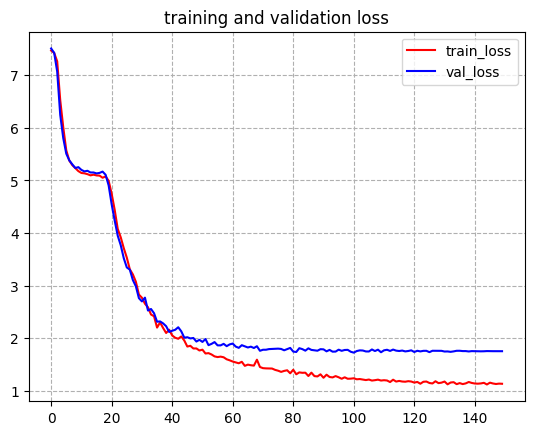

In [1]:
from log_record import record_log, read_log
from utils import visual_train

history = read_log("/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230922/unetlogs/log.txt")
visual_train(history)

no accuracy, only loss.


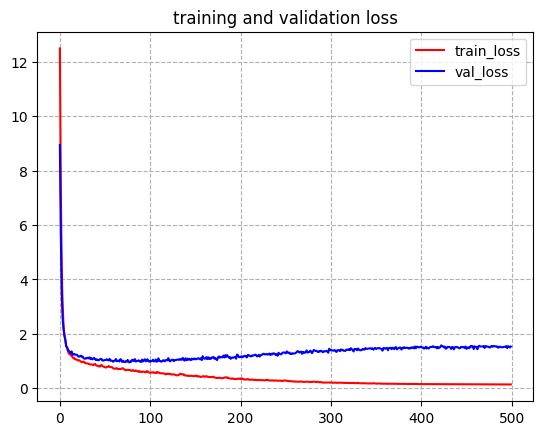

In [2]:
from log_record import record_log, read_log
from utils import visual_train

history = read_log("/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb/output/20230816_1/unetlogs/log.txt")
visual_train(history)